In [ ]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
from nltk.corpus import wordnet
import pickle
import multiprocessing as mp

print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)
def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)
def lemmaWord(word):
    lemma = wordnet.morphy(word)
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text)
    tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if i.lower() not in stopwordEn and i.isalpha()]
    if gram<=1:
        return tokens
    else:
        return [i for i in nltk.ngrams(tokens, gram)]

# Word2Vec Test

In [7]:
# https://radimrehurek.com/gensim/models/word2vec.html
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
# model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model") # 可以追加训练
# model.save_word2vec_format('/tmp/mymodel.txt',binary = False) # 不能追加训练
# model.save_word2vec_format('/tmp/mymodel.bin.gz',binary = True) # 不能追加训练
# model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.txt',binary = False)
#model = gensim.models.KeyedVectors。load_word2vec_format('/tmp/vectors.bin',binary = True)
##使用gzipped / bz2输入也可以，不需要解压：
#model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.bin.gz',binary=True)

In [4]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [8]:
model.wv['computer']

array([ 1.3179476e-03, -3.6557708e-03,  1.4724946e-03, -4.6163248e-03,
        3.9103902e-03,  3.1141383e-03,  1.5009028e-03,  4.4893189e-03,
        5.2202039e-04,  9.7013981e-04, -2.8035352e-03, -3.8041167e-03,
        2.0157928e-03, -3.5805621e-03,  3.4785629e-03,  4.4850325e-03,
       -1.7499849e-03,  1.9784337e-03, -4.5823082e-03,  1.6231141e-03,
        3.1153674e-03,  2.7094260e-03,  1.8231571e-03, -2.9738939e-03,
        4.3418691e-03,  3.4404420e-03,  2.9024770e-03, -4.8072677e-04,
       -2.3275960e-04, -3.7919483e-03,  2.5807766e-03, -1.1221850e-03,
        2.5485039e-03,  4.0816348e-03, -9.7584928e-04,  1.1280359e-03,
       -2.7548049e-03, -5.1507668e-04, -4.0222923e-03,  7.5863441e-04,
       -2.3035246e-03,  4.0134592e-03, -2.4739201e-03, -4.0585403e-03,
        2.1729709e-03, -4.8947614e-04,  1.7371685e-03, -8.7037479e-05,
        1.4716270e-03, -3.3620361e-04, -2.1330062e-03,  1.3260146e-03,
        2.8648584e-03,  4.4387830e-03,  2.7401582e-03, -8.2159776e-04,
      

In [17]:
#转换为短语
from gensim.models import Phrases

bigram_transformer = Phrases(common_texts)
model = Word2Vec(bigram_transformer[common_texts], min_count=1)

In [22]:
from gensim.models import Word2Vec
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(sentences, min_count=1,size=2,seed=0)

In [9]:
model.wv['cat']

array([ 0.03192362, -0.24895912], dtype=float32)

In [20]:
# 相同实现方式
from gensim.models import Word2Vec
sentences = [["cat kitty", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(min_count=1,size=2,seed=0)
model.build_vocab(sentences)  # prepare the model vocabulary
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) 

(1, 30)

In [68]:
model.wv['cat']

array([-0.16061567,  0.09959795], dtype=float32)

In [51]:
 model.wv.index2word

['say', 'cat', 'meow', 'dog', 'woof']

In [53]:
model.wv.most_similar('say')

[('cat', 0.9920650720596313),
 ('woof', 0.9271022081375122),
 ('dog', -0.5129150748252869),
 ('meow', -0.7269968390464783)]

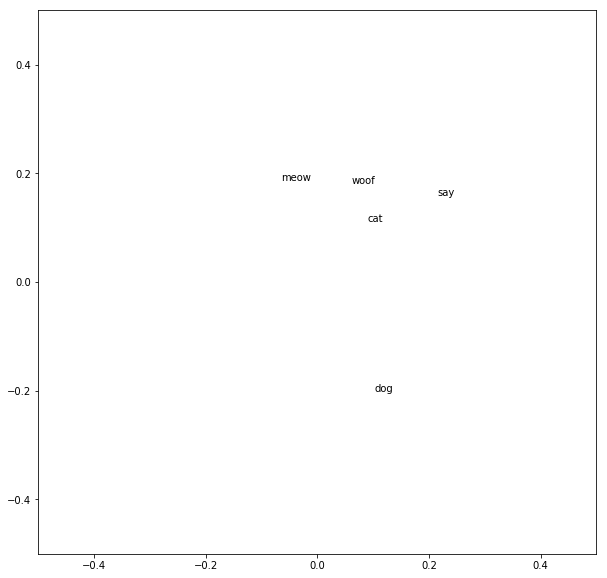

In [24]:
import numpy as np
import matplotlib.pyplot as plt

all_words = model.wv.index2word

for w in model.wv.index2word:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.show() 

In [ ]:
# https://mp.weixin.qq.com/s/aeoFx6sIX6WNch51XRF5sg
# https://zhuanlan.zhihu.com/p/75391062
# http://gavinhuang.github.io/blog/keras-based-word2vec-tutorial/
# https://keras-cn.readthedocs.io/en/latest/legacy/blog/word_embedding/
# https://www.flyml.net/2017/11/26/deepnlp-keras-pre-trained-word2vec-explaination/

# https://wizardforcel.gitbooks.io/hyry-studio-scipy/content/9.html
# https://docs.enthought.com/mayavi/mayavi/mlab.html
# https://www.cnblogs.com/yuyukun/p/12063595.html
# https://blog.csdn.net/Imkiimki/article/details/89483306
# https://keras-cn.readthedocs.io/en/latest/legacy/blog/word_embedding/
# http://research.google.com/bigpicture/

#利用most_similar() 做聚类
#https://blog.csdn.net/laobai1015/article/details/86540813 参数解释

# Get Tweets and News Subset

In [2]:
# Tweets_News
dates = range(23,30)
dfs_news, dfs_tweets={},{}

for d in tqdm(dates):
    with open('./IEEE_news/df_03{}_news.pickle'.format(d), 'rb') as handle:
        dfs_news[d] = pickle.load(handle)
    with open('./IEEE_tweets/df_03{}_tweets.pickle'.format(d), 'rb') as handle:
        dfs_tweets[d] = pickle.load(handle)

100%|██████████| 7/7 [00:39<00:00,  5.62s/it]


In [3]:
sampling_rate_news = 0.01
sampling_rate_tweets = 0.0635771

news_subset,tweets_subset = [],[]
for d in dates:
    unique_news = dfs_news[d].text.unique()
    retweets = dfs_tweets[d][dfs_tweets[d]['re_full_text']!='']['re_full_text'] # 转发的原文
    orig_tweets = dfs_tweets[d][dfs_tweets[d]['re_full_text']=='']['full_text'] #原创的且未在这个时间段被转发过
    unique_tweets = pd.concat([retweets,orig_tweets]).unique()
    
    np.random.seed(1)
    news_subset.extend(np.random.choice(unique_news, size=int(len(unique_news)*sampling_rate_news), replace=False))
    np.random.seed(1)
    tweets_subset.extend(np.random.choice(unique_tweets, size=int(len(unique_tweets)*sampling_rate_tweets), replace=False))
    
print('subset:',len(news_subset),len(tweets_subset))

subset: 6583 147223


In [4]:
tokens_tweets = apply_by_multiprocessing(pd.Series(tweets_subset), processText, workers=32, lemma=True) 
tokens_news = apply_by_multiprocessing(pd.Series(news_subset), processText, workers=32, lemma=True)

In [5]:
(sum([len(i) for i in tokens_news])),(sum([len(i) for i in tokens_tweets]))

(1805923, 1805755)

In [86]:
#句子变形前
nltk.sent_tokenize(news_subset[0])[0]

'Toronto, CANADA, March 23, 2020 (GLOBE NEWSWIRE) — Intelex Technologies , a leading global provider of SaaS-based Environmental, Health, Safety and Quality (EHSQ) management software, announced today that it is offering access to focused components of its EHSQ software platform free of charge to those on the front lines of the battle against COVID-19.'

In [87]:
#句子变形后
' '.join(processText(nltk.sent_tokenize(news_subset[0])[0],lemma=True))

'toronto canada march globe newswire intelex technology leading global provider environmental health safety quality ehsq management software announce today offering access focus component ehsq software platform free charge front line battle'

# Word Embedding Plot

## Tweets

In [31]:
#tweets
model = Word2Vec(tokens_tweets, size=2, window=5, min_count=1, workers=4, seed=0)

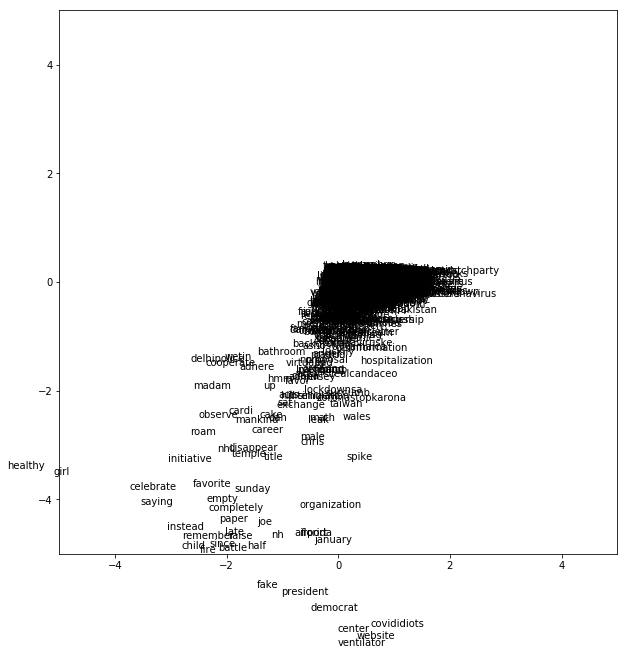

In [32]:
np.random.seed(1)
subset_words = np.random.choice(model.wv.index2word, size = 2000 ,replace=False)
for w in subset_words:
#     print(model.wv[w])
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

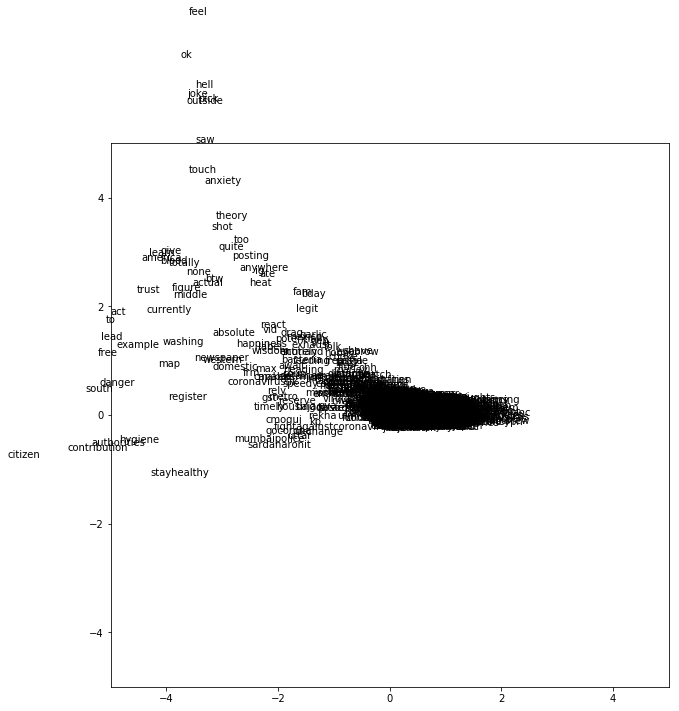

In [292]:
np.random.seed(1)
subset_words = np.random.choice(model.wv.index2word, size = 2000 ,replace=False)
for w in subset_words:
#     print(model.wv[w])
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

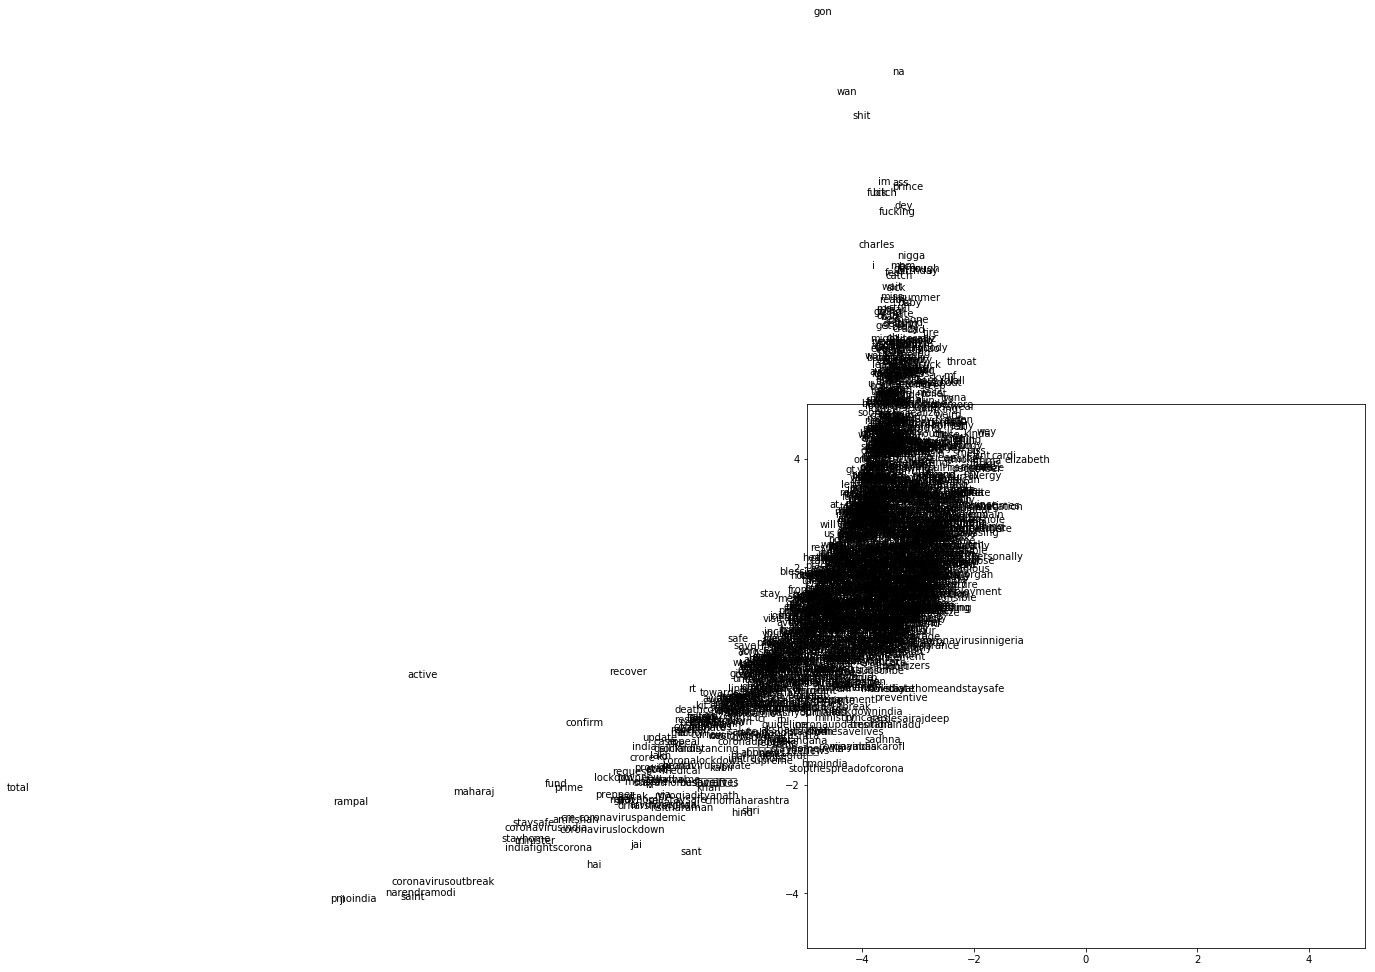

In [293]:
subset_words = model.wv.index2word[:2000]
for w in subset_words:
#     print(model.wv[w])
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

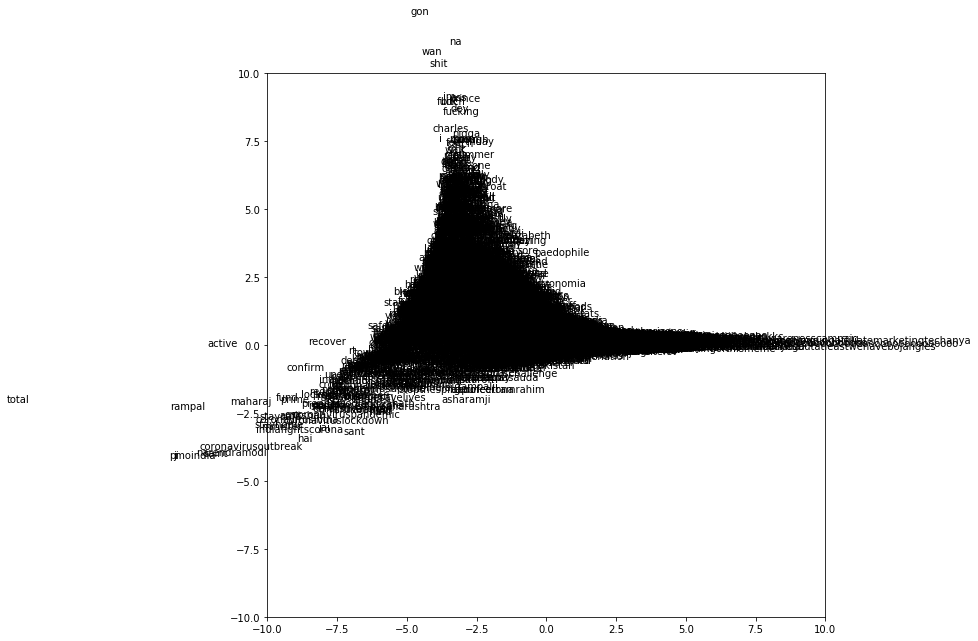

In [294]:
subset_words = model.wv.index2word
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show() 

## News

In [181]:
# news
model = Word2Vec(tokens_news, size=2, window=5, min_count=1, workers=4)

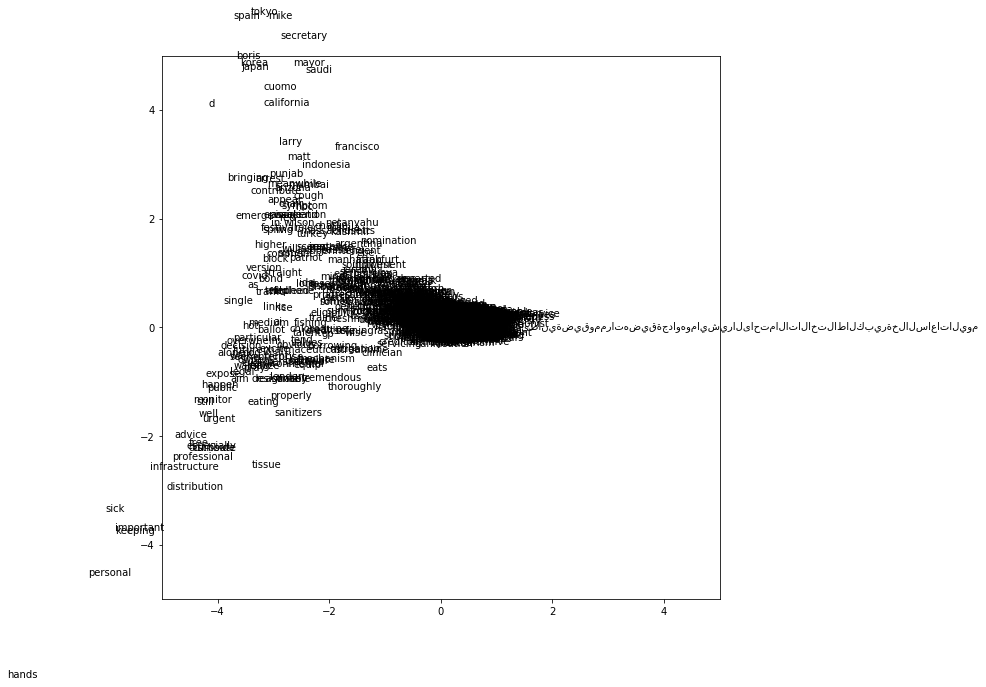

In [163]:
np.random.seed(1)
subset_words = np.random.choice(model.wv.index2word, size = 2000 ,replace=False)
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

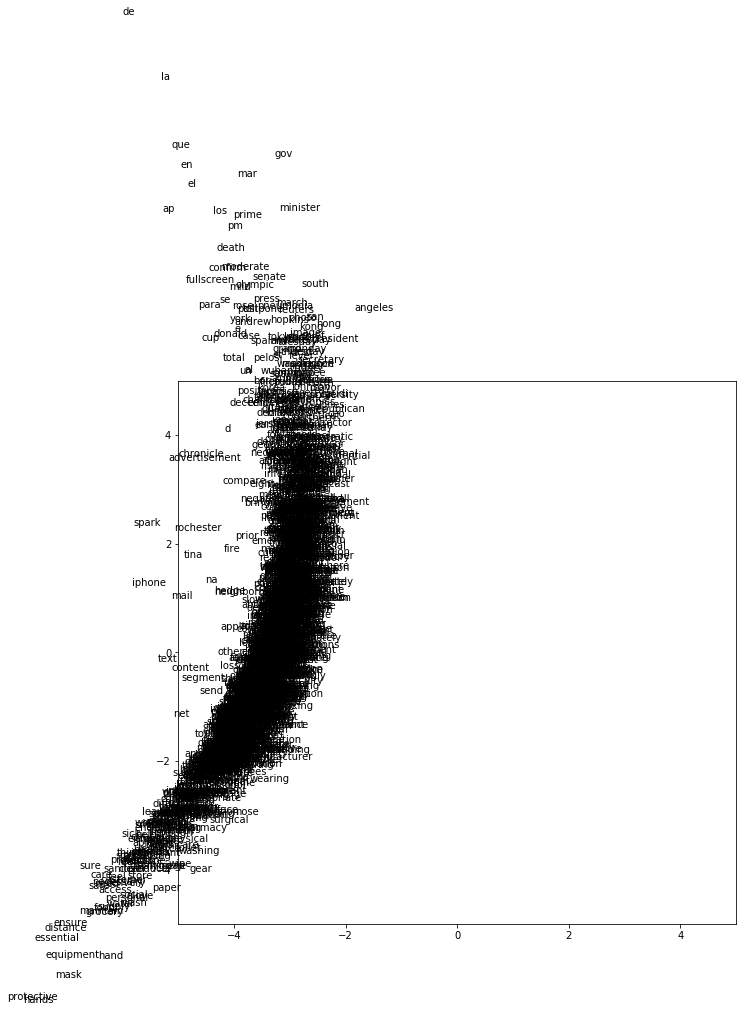

In [164]:
subset_words = model.wv.index2word[:2000]
for w in subset_words:
#     print(model.wv[w])
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

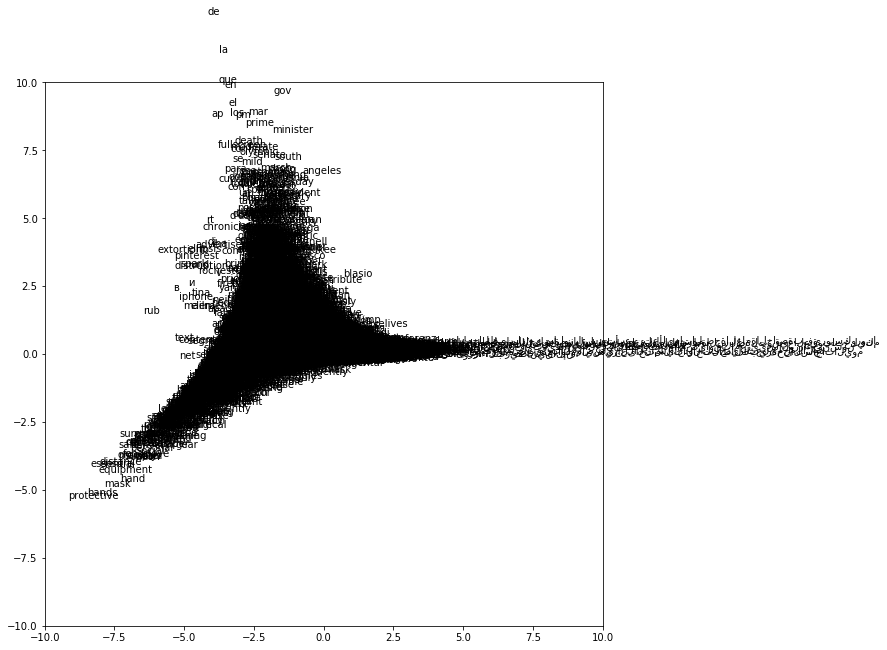

In [182]:
subset_words = model.wv.index2word
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show() 

## News + Tweets

In [204]:
# news + tweets
model = Word2Vec(pd.concat([tokens_tweets,tokens_news]), size=2, window=5, min_count=1, workers=4)

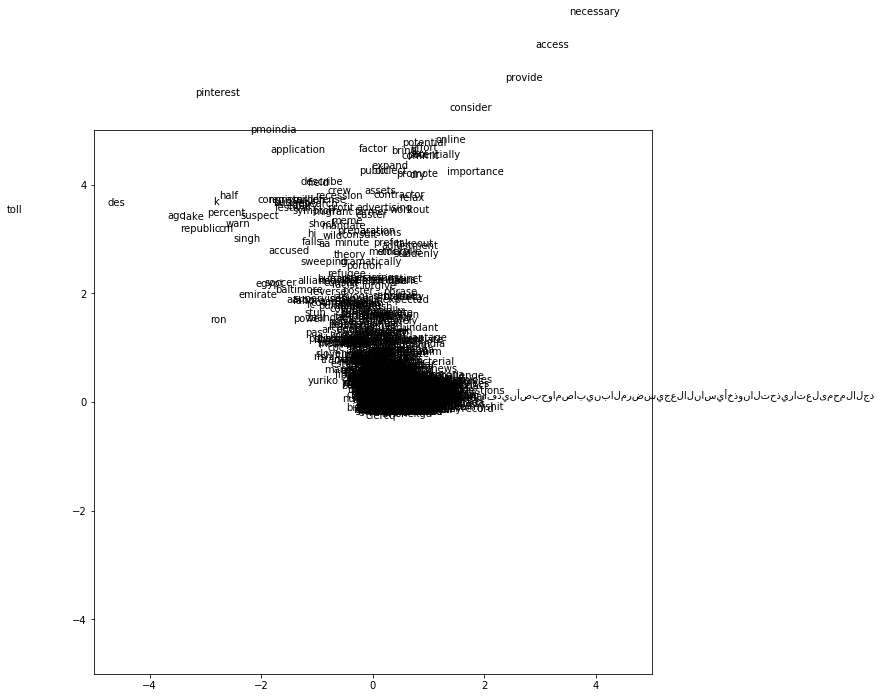

In [176]:
np.random.seed(1)
subset_words = np.random.choice(model.wv.index2word, size = 2000 ,replace=False)
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

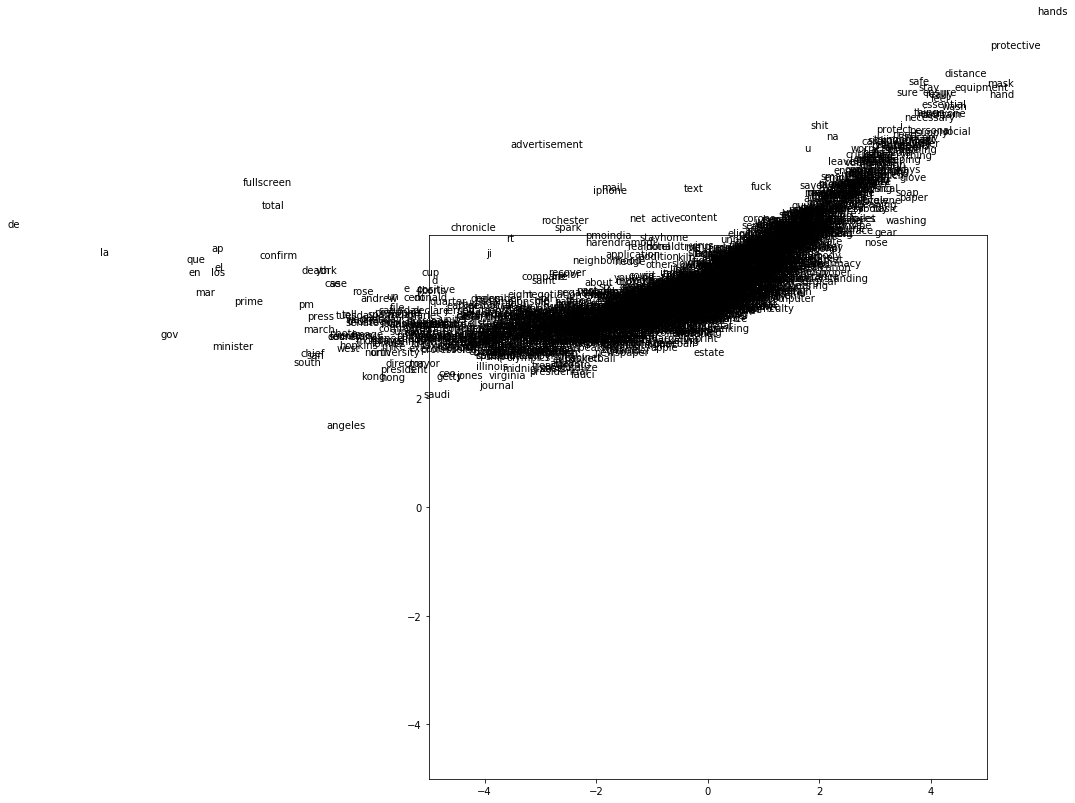

In [175]:
subset_words = model.wv.index2word[:2000]
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show() 

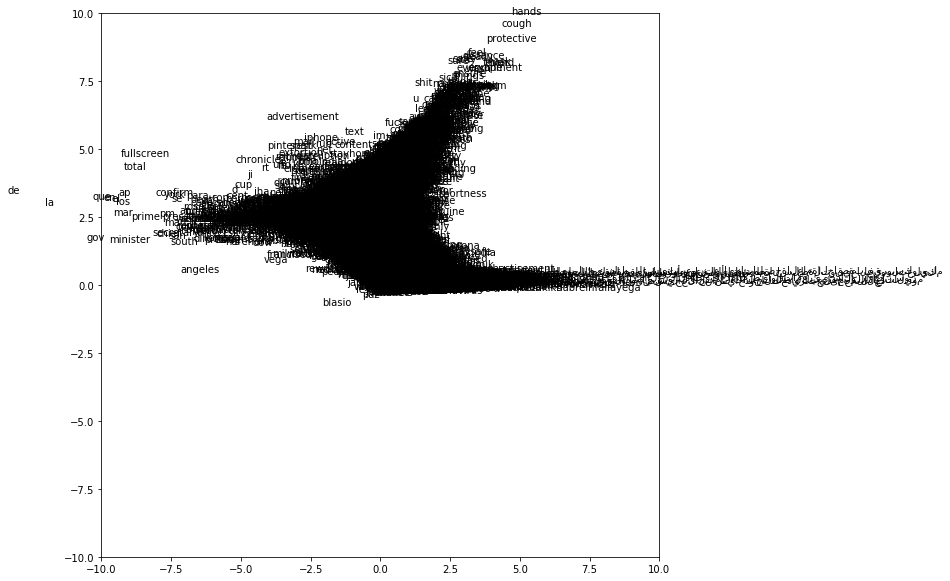

In [205]:
subset_words = model.wv.index2word
for w in subset_words:
    plt.text(model.wv[w][0], model.wv[w][1], w)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show() 

# 3D Word Embedding

In [ ]:
# https://www.cnblogs.com/cloud-ken/p/9329703.html Tensorboard
# https://zhuanlan.zhihu.com/p/24252690
# https://blog.csdn.net/u_say2what/article/details/93137229
# t-sne https://zhuanlan.zhihu.com/p/64664346
# https://distill.pub/2016/misread-tsne/ how to use t-sne

In [8]:
# news
model_news = Word2Vec(tokens_news, size=3, window=5, min_count=1, workers=4)

In [9]:
subset_words_news = model_news.wv.index2word
print(len(subset_words_news))
vectors_news = []
for w in subset_words_news:
    vectors_news.append(model_news.wv[w])

56529


In [252]:
pd.DataFrame(vectors_news).to_csv('./WordEmbeddings/news_subset_vectors', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_news).to_csv('./WordEmbeddings/news_subset_labels', sep='\t',index=False, header=False)
pd.DataFrame(vectors_news[:2000]).to_csv('./WordEmbeddings/news_subset_vectors_top2000', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_news[:2000]).to_csv('./WordEmbeddings/news_subset_labels_top2000', sep='\t',index=False, header=False)

In [10]:
# Tweets
model_tweets = Word2Vec(tokens_tweets, size=3, window=5, min_count=1, workers=4)
subset_words_tweets = model_tweets.wv.index2word
print(len(subset_words_tweets))
vectors_tweets = []
for w in subset_words_tweets:
    vectors_tweets.append(model_tweets.wv[w])

107697


In [269]:
pd.DataFrame(vectors_tweets).to_csv('./WordEmbeddings/tweets_subset_vectors', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_tweets).to_csv('./WordEmbeddings/tweets_subset_labels', sep='\t',index=False, header=False)
pd.DataFrame(vectors_tweets[:2000]).to_csv('./WordEmbeddings/tweets_subset_vectors_top2000', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_tweets[:2000]).to_csv('./WordEmbeddings/tweets_subset_labels_top2000', sep='\t',index=False, header=False)

In [11]:
# Tweets + News
model_all = Word2Vec(pd.concat([tokens_tweets,tokens_news]), size=3, window=5, min_count=1, workers=4)
subset_words_all = model_all.wv.index2word
print(len(subset_words_all))
vectors_all = []
for w in subset_words_all:
    vectors_all.append(model_all.wv[w])
pd.DataFrame(vectors_all).to_csv('./WordEmbeddings/both_subset_vectors', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_all).to_csv('./WordEmbeddings/both_subset_labels', sep='\t',index=False, header=False)
pd.DataFrame(vectors_all[:2000]).to_csv('./WordEmbeddings/both_subset_vectors_top2000', sep='\t',index=False, header=False)
pd.DataFrame(subset_words_all[:2000]).to_csv('./WordEmbeddings/both_subset_labels_top2000', sep='\t',index=False, header=False)

140570


# K-means clustering

In [64]:
# subset_words = model.wv.index2word
# print(len(subset_words))
# vectors = []
# for w in subset_words:
#     vectors.append(model.wv[w])
# vectors = np.array(vectors)

105624


## News

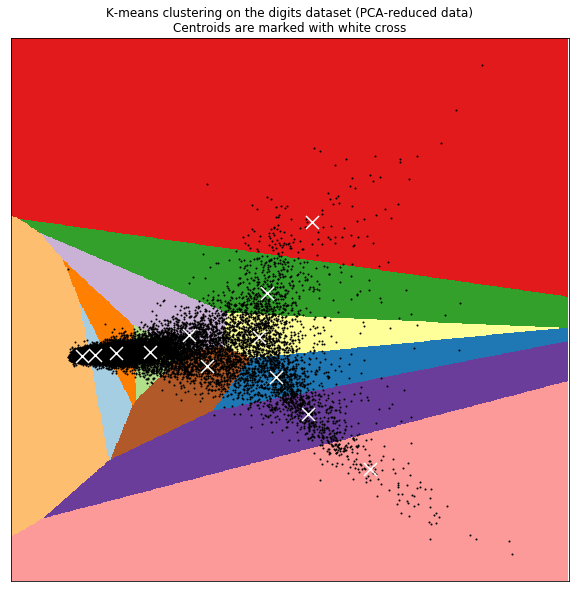

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

vectors = PCA(n_components=2).fit_transform(vectors_news) #高维度PCA降维到2维

estimator = KMeans(n_clusters=12,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

# https://blog.csdn.net/sinat_26917383/article/details/70240628
# https://blog.csdn.net/qq_34104548/article/details/79336584
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = vectors[:, 0].min() - 1, vectors[:, 0].max() + 1
y_min, y_max = vectors[:, 1].min() - 1, vectors[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


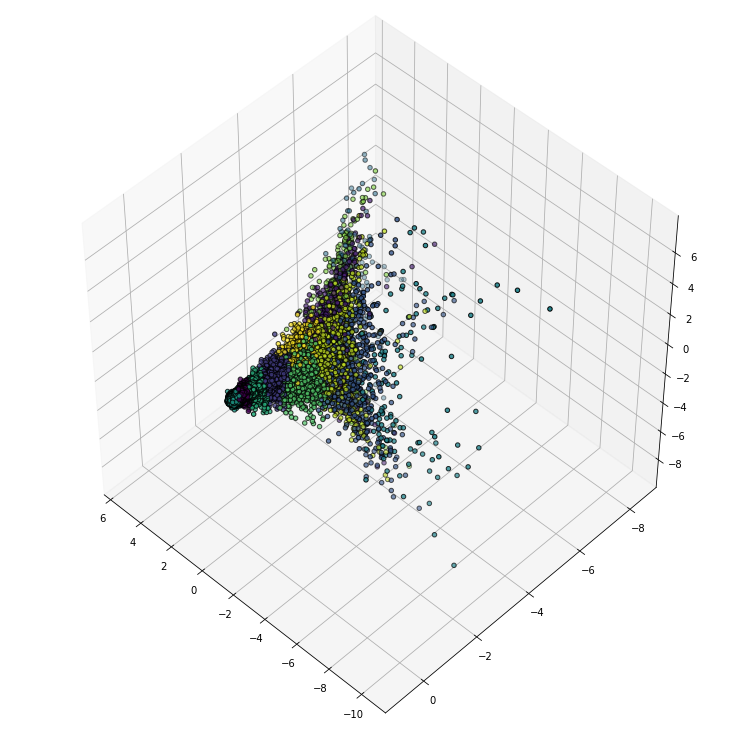

In [16]:
from mpl_toolkits.mplot3d import Axes3D
vectors = np.array(vectors_news)
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
labels = label_pred
ax.scatter(vectors[:, 1], vectors[:, 0], vectors[:, 2],c=labels.astype(np.float), edgecolor='k')

In [20]:
df_kmeans_news = pd.DataFrame(vectors_news, columns=['pca1','pca2','pca3'])
df_kmeans_news['text'] = subset_words_news
df_kmeans_news['label'] = label_pred
df_kmeans_news.head(20)

,pca1,pca2,pca3,text,label
0,-2.521993,-2.053073,-0.717327,say,10
1,-2.689747,-3.655064,-2.489104,coronavirus,3
2,-3.760062,0.147008,-1.613089,people,9
3,-4.978491,-1.516871,-7.792768,health,9
4,-2.248086,-3.533714,-2.544898,new,3
5,-2.938110,-3.047847,-4.490344,state,10
6,-1.904356,-6.521440,-1.004590,march,5
7,-3.754674,0.054862,-1.529083,also,1
8,-2.923223,-7.479511,-3.489985,case,5
9,-4.344738,0.961056,-2.378450,home,9


In [21]:
df_kmeans_news.groupby('label').apply(lambda x: list(x['text'][:5])).to_frame()

,0
label,
0,"[puget, everett, villanueva, whitty, baptism]"
1,"[also, would, take, us, like]"
2,"[sneeze, exam, checkpoint, gon, vancouver]"
3,"[coronavirus, new, week, first, world]"
4,"[need, business, help, work, company]"
5,"[march, case, last, president, trump]"
6,"[paso, masse, elton, kanter, juniac]"
7,"[blasio, instacart, investigator, imran, elli]"
8,"[treasury, poll, missouri, indefinitely, congr..."


## Tweets

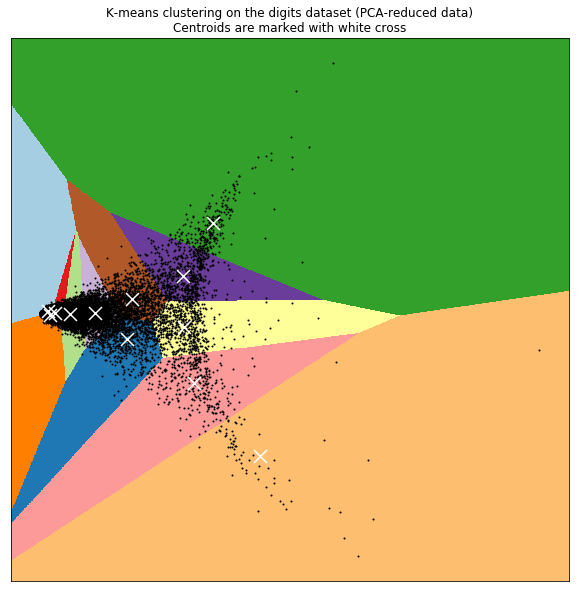

In [26]:
vectors = PCA(n_components=2).fit_transform(vectors_tweets) #高维度PCA降维到2维

estimator = KMeans(n_clusters=12,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = vectors[:, 0].min() - 1, vectors[:, 0].max() + 1
y_min, y_max = vectors[:, 1].min() - 1, vectors[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

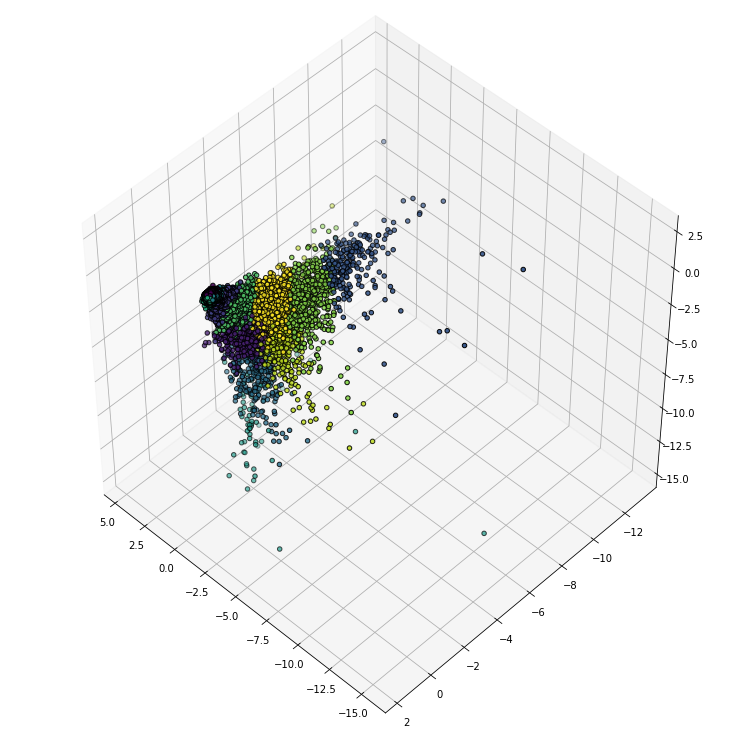

In [27]:
vectors = np.array(vectors_tweets)
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
labels = label_pred
ax.scatter(vectors[:, 1], vectors[:, 0], vectors[:, 2],c=labels.astype(np.float), edgecolor='k')

In [28]:
df_kmeans_tweets = pd.DataFrame(vectors_tweets, columns=['pca1','pca2','pca3'])
df_kmeans_tweets['text'] = subset_words_tweets
df_kmeans_tweets['label'] = label_pred
df_kmeans_tweets.head(20)

,pca1,pca2,pca3,text,label
0,-3.694452,-3.032028,-2.234672,corona,9
1,-3.342025,-3.561371,-2.135517,virus,9
2,-6.589571,-3.849541,-0.461732,get,3
3,-4.077031,-1.993683,-2.438344,people,9
4,-5.669576,-2.935623,-1.071423,like,3
5,-7.470652,-2.003270,-1.243351,go,3
6,-2.749403,-1.421927,-4.364988,amp,10
7,-4.969713,-0.390633,-3.456812,us,10
8,0.227814,-6.013618,-5.790455,coronavirus,4
9,-4.484237,-2.624713,-1.992836,one,9


In [29]:
df_kmeans_tweets.groupby('label').apply(lambda x: list(x['text'][:5])).to_frame()

,0
label,
0,"[harshu, mannn, restful, amish, arifaajakia]"
1,"[role, involve, restriction, whose, transmission]"
2,"[larry, welp, yikes, linkedin, curfewkenya]"
3,"[get, like, go, say, know]"
4,"[coronavirus, please, help, lockdown, pandemic]"
5,"[immunityboosters, nationbreaking, kthopkins, ..."
6,"[india, fight, narendramodi, sir, health]"
7,"[artofquotation, corinnakopf, sushrutkwal, the..."
8,"[totalcases, overwhelm, imamofpeace, mitchellv..."


## Tweets + News

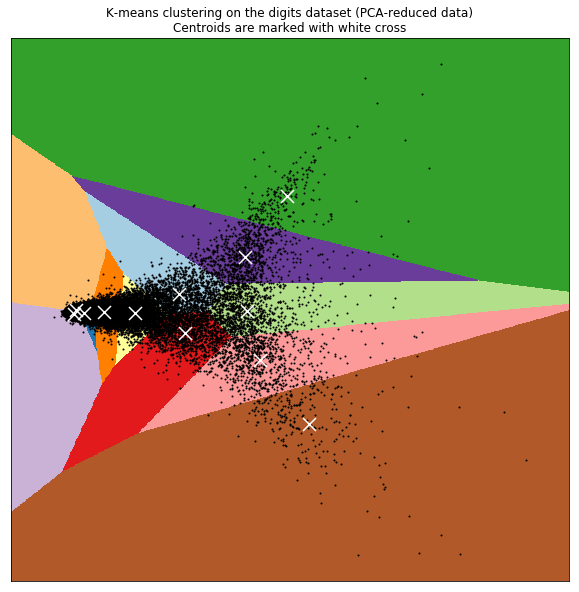

In [30]:
vectors = PCA(n_components=2).fit_transform(vectors_all) #高维度PCA降维到2维

estimator = KMeans(n_clusters=12,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = vectors[:, 0].min() - 1, vectors[:, 0].max() + 1
y_min, y_max = vectors[:, 1].min() - 1, vectors[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

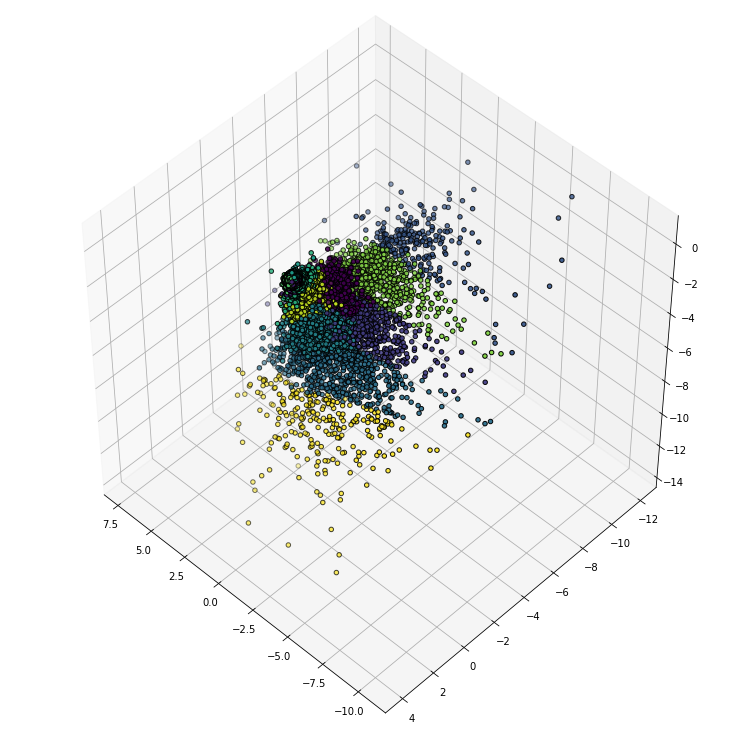

In [31]:
vectors = np.array(vectors_all)
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
labels = label_pred
ax.scatter(vectors[:, 1], vectors[:, 0], vectors[:, 2],c=labels.astype(np.float), edgecolor='k')

In [32]:
df_kmeans_all = pd.DataFrame(vectors_all, columns=['pca1','pca2','pca3'])
df_kmeans_all['text'] = subset_words_all
df_kmeans_all['label'] = label_pred
df_kmeans_all.head(20)

,pca1,pca2,pca3,text,label
0,-3.824587,-1.053329,-2.575093,corona,9
1,-3.618975,-0.819705,-2.665415,virus,9
2,-2.358846,-0.310992,-2.643902,say,2
3,-4.112368,-3.430947,-1.436943,people,9
4,0.065738,-0.406776,-5.227973,coronavirus,4
5,-6.906227,-1.826815,-1.016196,get,3
6,-4.213029,-1.442662,-1.689749,one,9
7,-5.983466,-1.161599,-1.316990,like,3
8,-4.509880,-6.778413,-1.427423,home,9
9,-4.418274,-3.006962,-1.291287,time,9


In [34]:
df_kmeans_all.groupby('label').apply(lambda x: list(x['text'][:5])).to_frame()

,0
label,
0,"[trump, ticket, fault, standing, actor]"
1,"[sahib, gregory, motley, copyshortcut, costco]"
2,"[say, also, world, help, amp]"
3,"[get, like, go, make, stay]"
4,"[coronavirus, new, country, pandemic, test]"
5,"[amazon, speech, ny, newspaper, jones]"
6,"[sic, polite, enzler, tanamongeau, kalissa]"
7,"[blasio, plummet, carlson, qualification, abus..."
8,"[masse, fnb, paso, azad, harshu]"


## Tweets + News Top 2000

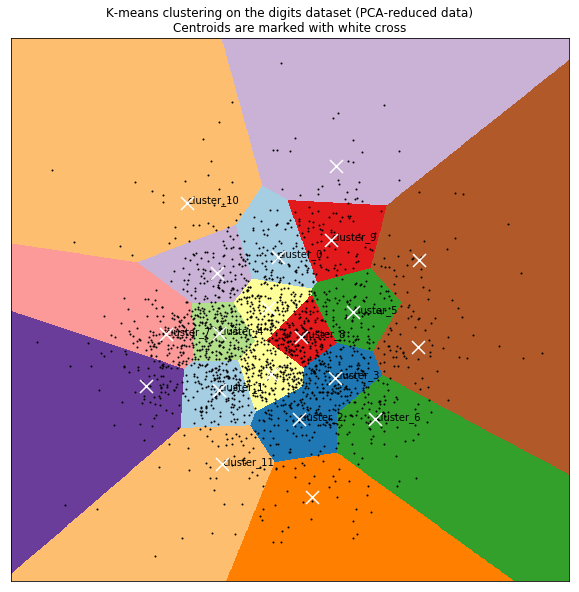

In [63]:
vectors = PCA(n_components=2).fit_transform(vectors_all[:2000]) #高维度PCA降维到2维

estimator = KMeans(n_clusters=20,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = vectors[:, 0].min() - 1, vectors[:, 0].max() + 1
y_min, y_max = vectors[:, 1].min() - 1, vectors[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
for c in range(12):
    plt.text(centroids[c, 0], centroids[c, 1],f'cluster_{c}')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

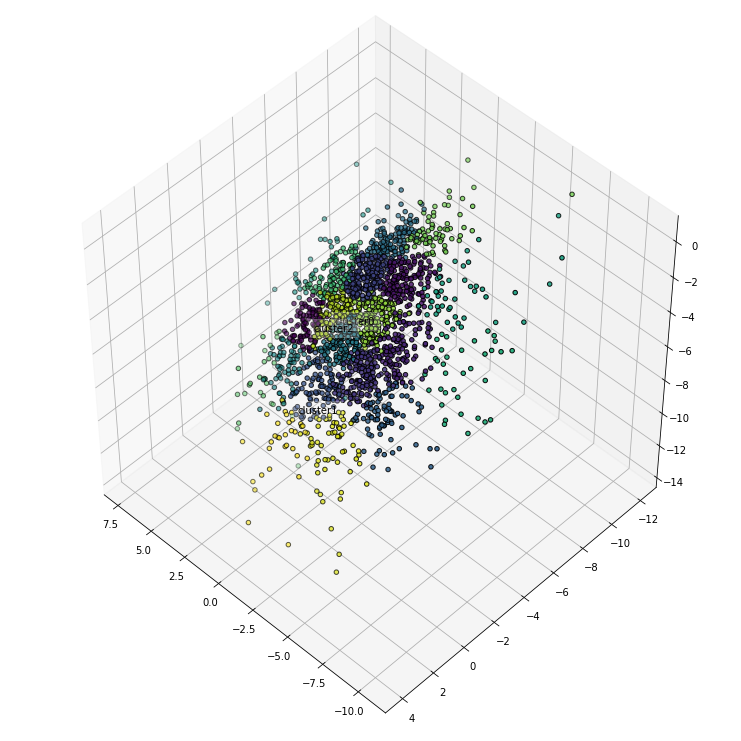

In [67]:
vectors = np.array(vectors_all[:2000])
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
labels = label_pred
ax.scatter(vectors[:, 1], vectors[:, 0], vectors[:, 2],c=labels.astype(np.float), edgecolor='k')

for c in range(1|2):
    X = df_kmeans_2000[df_kmeans_2000['label']==c]
    ax.text3D(X['pca1'].mean(),X['pca2'].mean(),X['pca3'].mean(), f'cluster{c}',horizontalalignment='center',
             bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))

In [68]:
df_kmeans_2000 = pd.DataFrame(vectors_all[:2000], columns=['pca1','pca2','pca3'])
df_kmeans_2000['text'] = subset_words_all[:2000]
df_kmeans_2000['label'] = label_pred
df_kmeans_2000.head(20)

,pca1,pca2,pca3,text,label
0,-3.824587,-1.053329,-2.575093,corona,4
1,-3.618975,-0.819705,-2.665415,virus,4
2,-2.358846,-0.310992,-2.643902,say,17
3,-4.112368,-3.430947,-1.436943,people,1
4,0.065738,-0.406776,-5.227973,coronavirus,5
5,-6.906227,-1.826815,-1.016196,get,15
6,-4.213029,-1.442662,-1.689749,one,4
7,-5.983466,-1.161599,-1.316990,like,7
8,-4.509880,-6.778413,-1.427423,home,11
9,-4.418274,-3.006962,-1.291287,time,1


In [70]:
df_kmeans_2000.groupby('label').apply(lambda x: list(x['text'][:10])).to_frame()

,0
label,
0,"[new, test, china, news, positive, disease, ap..."
1,"[people, time, us, make, take, would, want, ev..."
2,"[please, use, continue, place, working, commun..."
3,"[also, spread, include, hospital, patient, fig..."
4,"[corona, virus, one, come, day, days, tell, st..."
5,"[coronavirus, lockdown, india, outbreak, city,..."
6,"[government, public, order, company, support, ..."
7,"[like, know, see, back, god, look, next, sympt..."
8,"[country, pandemic, due, million, share, bill,..."


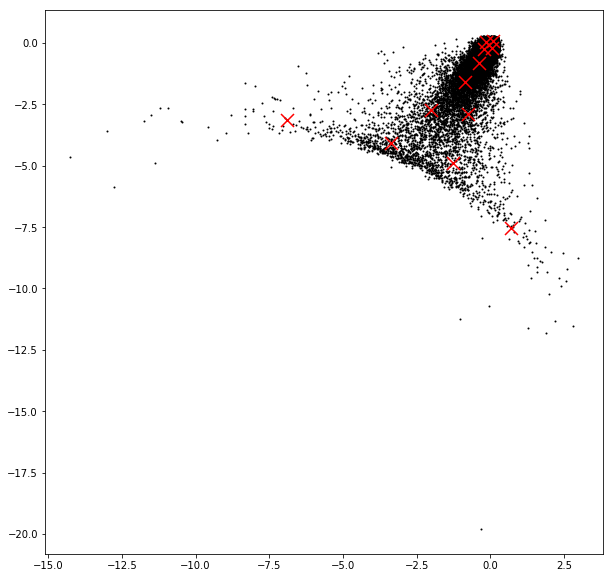

In [77]:
# test
plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

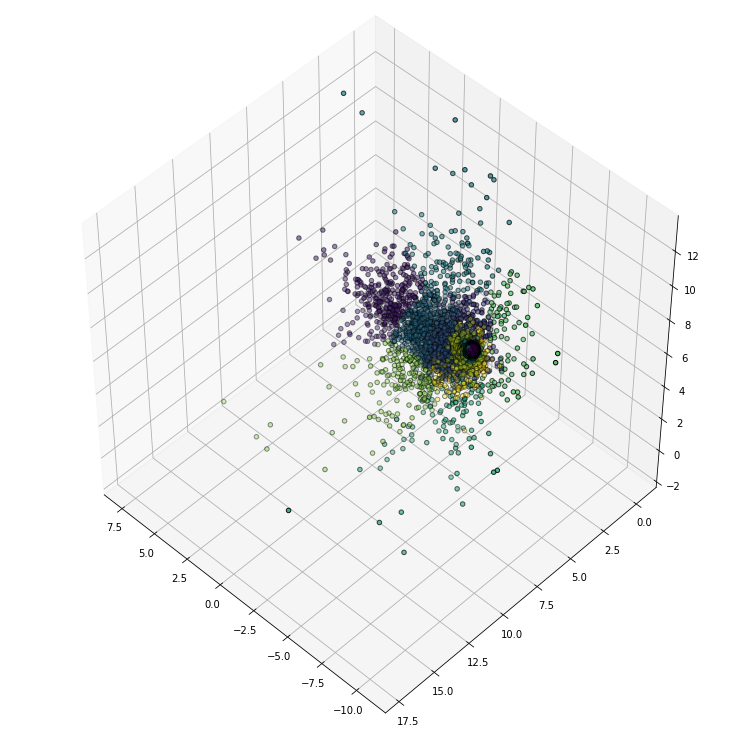

In [155]:
from mpl_toolkits.mplot3d import Axes3D

#     https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
    estimator = KMeans(n_clusters=12)#构造聚类器
    estimator.fit(vectors)#聚类
    label_pred = estimator.labels_ #获取聚类标签
    centroids = estimator.cluster_centers_ #获取聚类中心
    inertia = estimator.inertia_ # 获取聚类准则的总和
vectors = np.array(vectors)
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)
labels = label_pred
ax.scatter(vectors[:, 1], vectors[:, 0], vectors[:, 2],c=labels.astype(np.float), edgecolor='k')

In [ ]:
#test

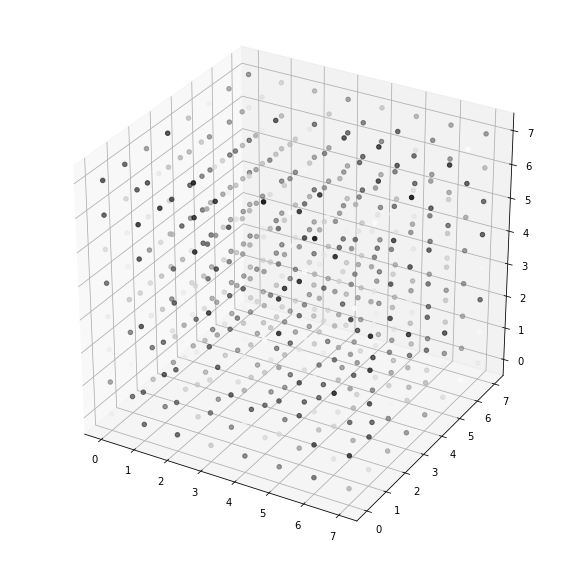

In [558]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Make this bigger to generate a dense grid.
N = 8

# Create some random data.
volume = np.random.rand(N, N, N)

# Create the x, y, and z coordinate arrays.  We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(volume.shape[0])[:, None, None]
y = np.arange(volume.shape[1])[None, :, None]
z = np.arange(volume.shape[2])[None, None, :]
x, y, z = np.broadcast_arrays(x, y, z)

# Turn the volumetric data into an RGB array that's
# just grayscale.  There might be better ways to make
# ax.scatter happy.
c = np.tile(volume.ravel()[:, None], 3)

# Do the plotting in a single call.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(),
           c=c)

In [604]:
x.shape

(75304,)

In [603]:
x,y,z = np.array(vectors).reshape(3,75304)

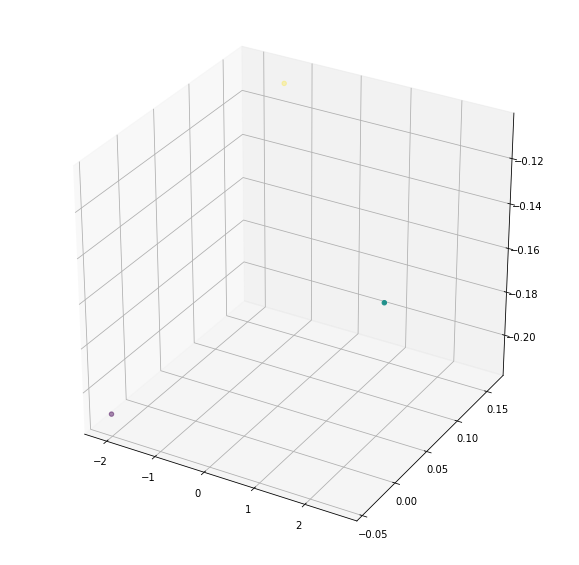

In [612]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x[:3],
           y[:3],
           z[:3],
          c=[0,1,2])